# IAQ and Fitbit-Measured Sleep Exploration
Arguably the main attraction (for me at least), we explore the effect of IAQ parameters on Fitbit-measured sleep parameters.

In [1]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

# Nightly Pollutant Exposures and Sleep Quality
The purpose of this notebook is to look at the in-depth relationships between IAQ and sleep quality, some of which has already been looked at in another notebook which has been copied here.

In [2]:
import os
import sys
sys.path.append('../')

from src.features import build_features
from src.visualization import visualize
from src.reports import make_report

import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import matplotlib.dates as mdates
from joypy import joyplot

import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats

# Data Import
For this analysis we need all reports of sleep quality in addition to the IEQ data and ventilation rates

### Fitbit Sleep Summary

In [3]:
fb_sleep = pd.read_csv("../data/processed/fitbit-sleep_summary-ux_s20.csv",parse_dates=["start_time","end_time","start_date","end_date"],infer_datetime_format=True)#,index_col=["beiwe","start_time"])
for stage in ["rem","nrem"]:
    fb_sleep[f"{stage}_percent"] = fb_sleep[f"{stage}_minutes"] / (fb_sleep["tst_fb"]*60)
fb_sleep.head()

,start_date,end_date,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,beiwe,efficiency,end_time,start_time,redcap,beacon,nrem_count,rem2nrem_count,nrem_minutes,rem2nrem_minutes,tst_fb,rem_percent,nrem_percent
0,2020-05-14,2020-05-14,5,84,20,213,10,82,21,27,hfttkth7,97,2020-05-14 07:13:00,2020-05-14 00:27:00,NaN,NaN,25,0.400000,297,0.276094,6.766667,0.201970,0.731527
1,2020-05-14,2020-05-15,4,95,31,250,6,47,33,101,hfttkth7,87,2020-05-15 08:06:30,2020-05-14 23:53:30,NaN,NaN,35,0.171429,345,0.136232,8.216667,0.095335,0.699797
2,2020-05-15,2020-05-16,2,47,17,190,8,50,20,42,hfttkth7,95,2020-05-16 04:57:00,2020-05-15 23:28:00,NaN,NaN,19,0.421053,237,0.210970,5.483333,0.151976,0.720365
3,2020-05-17,2020-05-17,5,78,21,242,11,83,25,44,hfttkth7,96,2020-05-17 09:28:30,2020-05-17 02:01:30,NaN,NaN,26,0.423077,320,0.259375,7.450000,0.185682,0.715884
4,2020-05-18,2020-05-18,5,96,20,167,14,88,28,65,hfttkth7,92,2020-05-18 07:20:00,2020-05-18 00:24:00,NaN,NaN,25,0.560000,263,0.334601,6.933333,0.211538,0.632212


### Self-Report Sleep

In [4]:
beiwe_sleep = pd.read_csv("../data/processed/beiwe-morning_ema-ux_s20.csv",parse_dates=["timestamp"],infer_datetime_format=True)
beiwe_sleep.head()

,timestamp,beiwe,content,stress,lonely,sad,energy,tst,sol,naw,restful,redcap,beacon
0,2020-05-13 09:10:27,qh34m4r9,3,0.0,0.0,0.0,1.0,8.0,20.0,2.0,3.0,68,19.0
1,2020-05-13 09:15:49,awa8uces,0.0,2.0,1.0,1.0,1.0,2.0,10.0,3.0,1.0,28,26.0
2,2020-05-13 09:42:19,xxvnhauv,1,1.0,1.0,3.0,0.0,6.0,30.0,3.0,1.0,21,22.0
3,2020-05-13 09:43:27,rvhdl2la,1,1.0,2.0,3.0,0.0,5.3,5.0,2.0,2.0,29,NaN
4,2020-05-13 10:11:51,q5y11ytm,3,1.0,0.0,1.0,2.0,2.0,10.0,0.0,0.0,48,NaN


### Beacon IAQ
IAQ measurements courtesy of the beacons

In [5]:
ieq_raw = pd.read_csv("../data/processed/beacon-fb_and_gps_filtered_summary-ux_s20.csv",parse_dates=["start_time","end_time",],infer_datetime_format=True)
ieq_raw.drop([c for c in ieq_raw.columns if c.endswith("percent") or c.endswith("mean")],axis="columns",inplace=True)
for bad_label in ["long","lat","accuracy","altitude","rh","pm1","number"]:
    ieq_raw.drop([c for c in ieq_raw.columns if c.startswith(bad_label)],axis="columns",inplace=True)

ieq = ieq_raw.copy()
ieq.head()

,start_time,end_time,beacon,beiwe,fitbit,redcap,tvoc_median,lux_median,no2_median,co_median,co2_median,pm2p5_number_median,pm2p5_mass_median,temperature_c_median,tvoc_delta,lux_delta,no2_delta,co_delta,co2_delta,pm2p5_number_delta,pm2p5_mass_delta,temperature_c_delta
0,2020-08-10 04:42:30,2020-08-10 12:35:30,21,lkkjddam,25,12,126.658333,2.040,NaN,10.359917,1600.754959,0.914249,0.895571,23.337500,91.90,0.136,NaN,0.731650,304.035761,1.960803,0.620298,1.000
1,2020-08-11 03:35:00,2020-08-11 12:36:30,21,lkkjddam,25,12,233.566667,2.040,NaN,6.429275,1628.474180,1.287357,0.847762,25.000000,160.45,0.204,NaN,5.565250,202.651343,6.086460,0.665257,1.650
2,2020-08-12 02:59:30,2020-08-12 10:52:30,21,lkkjddam,25,12,252.016667,2.040,NaN,10.271850,1596.122408,2.879650,0.939256,24.000000,108.60,0.204,NaN,0.512533,146.009840,5.472740,0.702017,0.000
3,2020-08-14 03:05:00,2020-08-14 11:23:30,21,lkkjddam,25,12,223.700000,1.938,NaN,7.232700,1301.449844,1.232406,0.886675,25.000000,81.80,2.040,NaN,5.108383,233.372161,3.742991,0.736714,1.175
4,2020-08-15 06:51:30,2020-08-15 11:30:00,21,lkkjddam,25,12,209.600000,2.040,NaN,10.886100,1274.110350,2.017288,1.046326,23.333333,149.30,0.136,NaN,0.684917,125.544723,43.415611,2.880943,1.000


### Beacon Ventilation Estimates
CO2-based ventilation rates

In [6]:
aer = pd.read_csv("../data/processed/beacon-ventilation.csv",parse_dates=["start","end"],infer_datetime_format=True)
aer["end_date"] = pd.to_datetime(aer["end"].dt.date)
aer.head()

,beacon,beiwe,start,end,ach,method,end_date
0,21.0,lkkjddam,2020-08-12 13:16:00,2020-08-12 13:38:00,0.151,decay,2020-08-12
1,21.0,lkkjddam,2020-08-16 13:36:00,2020-08-16 14:08:00,0.143,decay,2020-08-16
2,21.0,lkkjddam,2020-08-18 12:48:00,2020-08-18 13:22:00,0.202,decay,2020-08-18
3,21.0,lkkjddam,2020-08-20 12:26:00,2020-08-20 12:52:00,0.078,decay,2020-08-20
4,21.0,lkkjddam,2020-08-20 14:14:00,2020-08-20 14:44:00,0.062,decay,2020-08-20


# Fitbit-Measured Sleep
We start by looking at the response in Fitbit-measure sleep metrics

In [7]:
sleep_metrics = ["efficiency","rem2nrem_minutes","tst_fb","rem_percent","nrem_percent"]
ieq_and_fb_sleep = ieq.merge(right=fb_sleep,on=["start_time","end_time","beiwe","redcap","beacon"],how='inner', indicator=False)
ieq_and_fb_sleep = ieq_and_fb_sleep[ieq_and_fb_sleep["efficiency"] >= 70]

## Summary of Available Data
We just look at a few key values from the merged dataset.

In [8]:
print("Number of Observations:", len(ieq_and_fb_sleep))

Number of Observations: 278


In [9]:
print("Number of Participants:", len(ieq_and_fb_sleep["beiwe"].unique()))

Number of Participants: 15


In [10]:
ieq_and_fb_sleep.head()

,start_time,end_time,beacon,beiwe,fitbit,redcap,tvoc_median,lux_median,no2_median,co_median,co2_median,pm2p5_number_median,pm2p5_mass_median,temperature_c_median,tvoc_delta,lux_delta,no2_delta,co_delta,co2_delta,pm2p5_number_delta,pm2p5_mass_delta,temperature_c_delta,start_date,end_date,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,efficiency,nrem_count,rem2nrem_count,nrem_minutes,rem2nrem_minutes,tst_fb,rem_percent,nrem_percent
0,2020-08-10 04:42:30,2020-08-10 12:35:30,21,lkkjddam,25,12,126.658333,2.040,NaN,10.359917,1600.754959,0.914249,0.895571,23.337500,91.90,0.136,NaN,0.731650,304.035761,1.960803,0.620298,1.000,2020-08-10,2020-08-10,2,41,26,285,2,71,25,76,91,28,0.071429,326,0.217791,7.883333,0.150106,0.689218
1,2020-08-11 03:35:00,2020-08-11 12:36:30,21,lkkjddam,25,12,233.566667,2.040,NaN,6.429275,1628.474180,1.287357,0.847762,25.000000,160.45,0.204,NaN,5.565250,202.651343,6.086460,0.665257,1.650,2020-08-11,2020-08-11,4,62,40,300,5,93,35,86,96,44,0.113636,362,0.256906,9.016667,0.171904,0.669131
2,2020-08-12 02:59:30,2020-08-12 10:52:30,21,lkkjddam,25,12,252.016667,2.040,NaN,10.271850,1596.122408,2.879650,0.939256,24.000000,108.60,0.204,NaN,0.512533,146.009840,5.472740,0.702017,0.000,2020-08-12,2020-08-12,3,52,34,291,7,65,35,65,93,37,0.189189,343,0.189504,7.883333,0.137421,0.725159
3,2020-08-14 03:05:00,2020-08-14 11:23:30,21,lkkjddam,25,12,223.700000,1.938,NaN,7.232700,1301.449844,1.232406,0.886675,25.000000,81.80,2.040,NaN,5.108383,233.372161,3.742991,0.736714,1.175,2020-08-14,2020-08-14,4,49,38,299,6,76,38,74,90,42,0.142857,348,0.218391,8.300000,0.152610,0.698795
4,2020-08-15 06:51:30,2020-08-15 11:30:00,21,lkkjddam,25,12,209.600000,2.040,NaN,10.886100,1274.110350,2.017288,1.046326,23.333333,149.30,0.136,NaN,0.684917,125.544723,43.415611,2.880943,1.000,2020-08-15,2020-08-15,2,36,18,139,4,56,16,47,97,20,0.200000,175,0.320000,4.633333,0.201439,0.629496


In [11]:
def plot_data_availability_heatmap(df, df_filter='not', agg_str = "", save=False, save_dir='../reports/figures/'):
    '''
    Plots a heatmap showing number of nights the various beacons measured for each sensor
    
    Inputs
    - df: dataframe with columns in columns_to_use
    - df_filter: the naming convention of the filtering applied to the beacon - used when saving
    - savefig: boolean specifying whether or not to save the file
    - save_dir: string of the location to save the figure
    
    Returns the count dataframe used to generate the heatmap
    '''
    # filtering the dataframe to only include import vars
    var_list = ['lux','tvoc','co2','co','no2','pm2p5_mass']
    columns_to_use = [column + agg_str for column in var_list] + ['beacon','start_time']
    df_filtered = df.copy()[columns_to_use]
    # dict to store the values
    data = {f'lux{agg_str}':[],f'tvoc{agg_str}':[],f'co2{agg_str}':[],f'co{agg_str}':[],f'no2{agg_str}':[],f'pm2p5_mass{agg_str}':[],'beacon':[]}
    # looping through the dataframe to get the number of nights each beacon measured
    for bb in df_filtered['beacon'].unique():
        df_by_bb_by_night = df_filtered[df_filtered['beacon'] == bb]
        for var in columns_to_use:
            if var == "start_time":
                pass
            elif var == 'beacon':
                data['beacon'].append(bb)
            else:
                data[var].append(df_by_bb_by_night.count()[var])

    # formatting dataframe
    df_count = pd.DataFrame(data=data,index=data['beacon'])
    df_count.drop('beacon',axis=1,inplace=True)
    df_count.sort_index(inplace=True)
    
    # plotting heatmap
    fig, ax = plt.subplots(figsize=(12,5))
    sns.heatmap(df_count.sort_values(by=f'lux{agg_str}').T,square=True,annot=True,fmt="d",linewidths=.5,cmap="Blues",vmin=0,vmax=50,cbar_kws={"shrink":0.9,"pad":0.02},ax=ax)
    # reformatting figure labels
    ax.set_yticklabels(['Light','TVOC','CO$_2$','CO','NO$_2$','PM$_{2.5}$'],rotation=0)
    ax.set_xlabel('Beacon Number')
    #ax.set_title('Number of Nights Measured by BEVO Beacon')
    
    # saving and showing
    if save:
        plt.savefig(f'{save_dir}beacon_{df_filter}_filtered-data_availability-heatmap-ux_s20.pdf',bbox_inches='tight')
    plt.show()
    plt.close()
    
    return df_count

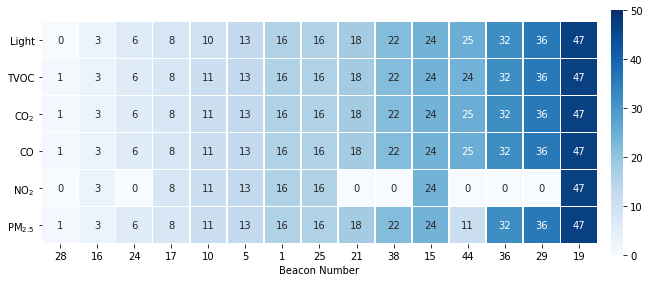

In [12]:
temp = plot_data_availability_heatmap(ieq_and_fb_sleep,agg_str="_median", save=True)

## Grouping Nights by Concentration
We can group each of the nights based on the median concentration value for each pollutant can compare that to sleep quality. However, to do so requires that we establish thresholds for low and high concentrations:
- **TVOCs**: The "short and long-term" [recommendation by the WHO](https://iaqscience.lbl.gov/voc-intro) is 100 ppb so `tvoc_threshold=100`
- **NO$_2$**: EPA provides outdoor standards where the most strict standard is the annual exposure limit at 53 ppb. The EPA's [discussion on indoor](https://www.epa.gov/indoor-air-quality-iaq/nitrogen-dioxides-impact-indoor-air-quality) NO$_2$ states that indoor concentration "[are] about half that of outdoors." Therefore, we will set `no2_threshold=25`. 
- **CO**: The WHO published a [study on CO guidelines](https://www.ncbi.nlm.nih.gov/books/NBK138710/) and recommended as low as 7 mg/m$^3$ which is approximately 6 ppm so `co_threshold=6`
- **CO$_2$**: [OSHA](https://ohsonline.com/Articles/2016/04/01/Carbon-Dioxide-Detection-and-Indoor-Air-Quality-Control.aspx?m=1&Page=2) and ASHRAE generally agree that concentrations above 1100 ppm tend to create some issues so `co2_threshold=1100`
- **PM2.5** (mass): Considering the EPA again, the outdoor annual exposure limit is 12 $\mu$g/m$^3$ and the [EPA mentions](https://www.epa.gov/indoor-air-quality-iaq/indoor-particulate-matter#Levels_in_Homes) that concentrations indoors would mirror outdoor concentrations absent of any indoor sources. However, that threshold is still too high so we use the median concentration from the study: `pm2p5_mass_threshold=1.5`
- **Temperature**: The ideal temperature range is between 60-67F which is lower than the minimum temperature that was measured. So we will use 27/80.6 (median temperature from the study) as a lower threshold and then increase slightly for the extra heat from the sensors so `temperature_c_threshold=27`.

### Visualizing and Running T-Test on Sleep Metrics
Now we can look at the distribution of sleep metrics for each pollutant profile and run a T-Test to see if there are _significant_ differences between the sleep metric results.

In [13]:
def run_ttest_ieq_and_sleep(df, pollutants=["tvoc","no2","co","co2","pm2p5_mass","temperature_c"], limits=[200,25,4,1100,1.5,27], sleep_device="fitbit", sleep_metrics=["tst_fb","rem2nrem_minutes","efficiency"], pollutant_metric="median", showfig=True, save=False):
    """
    
    """
    df_to_plot = df.copy()
    # adding "low"/"high" column for each pollutant
    thresholds = dict(zip(pollutants,limits))
    for pollutant, threshold in thresholds.items():
        df_to_plot[f"{pollutant}_level"] = np.where(df_to_plot[f"{pollutant}_{pollutant_metric}"] < threshold, "low","high")
    # creating dictionary to store p-values
    ttest_results = {}
    # looping through sleep metrics
    for sleep_metric in sleep_metrics:
        print(f"Running for: {sleep_metric.split('_')[0]}")
        # expanding the df to allow for easier plotting
        df_expanded = df_to_plot.melt(id_vars=[c for c in df_to_plot.columns if c.endswith("median") or c == sleep_metric],value_vars=[c for c in df_to_plot.columns if c.endswith("level")],value_name="level")
        # plotting
        fig,ax = plt.subplots(figsize=(16,6))
        sns.violinplot(x="variable",y=sleep_metric,hue="level",data=df_expanded,split=True,hue_order=["low","high"],palette={"low":"white","high":"#bf5700"},inner="quartile",cut=0,ax=ax)
        # x-axis
        ax.set_xticklabels([pollutant.split("_")[0].upper().replace("O2","O$_2$").replace("2P5","$_{2.5}$").replace(" C","").replace("TEMPERATURE","T") for pollutant in pollutants],fontsize=14)
        ax.set_xlabel("")
        # y-axis
        plt.setp(ax.get_yticklabels(), ha="right", rotation=0, fontsize=14)
        if sleep_metric not in ["efficiency"]:
            ax.set_ylabel(sleep_metric.split("_")[0].replace("2",":").upper().replace("N","n"),fontsize=16)
        else:
            ax.set_ylabel(sleep_metric.title(),fontsize=16)
        # Modifying Remainder
        ax.legend(bbox_to_anchor=(1.1,0.75),frameon=False,ncol=1,fontsize=12,title_fontsize=14,title="Median\nConcentration")
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)

        pvals = pd.DataFrame()
        for pollutant in pollutants:
            df = df_expanded[df_expanded["variable"] == f"{pollutant}_level"]
            low_vals = df[df["level"] == "low"]
            high_vals = df[df["level"] == "high"]
            _, p = stats.ttest_ind(low_vals[sleep_metric],high_vals[sleep_metric], equal_var=True)
            pvals = pvals.append(pd.DataFrame({"pollutant":[pollutant],"low":[len(low_vals)],"high":[len(high_vals)],"p_val":[p]}))

        ttest_results[sleep_metric.split("_")[0]] = pvals.set_index("pollutant")

        # Annotating with p-values
        xlocs = ax.get_xticks()
        ax.text(ax.get_xlim()[0],ax.get_ylim()[1],"          p:",ha="center",va="bottom",fontsize=12)
        for xloc, p in zip(xlocs,ttest_results[sleep_metric.split("_")[0]]["p_val"]):
            weight="bold" if p < 0.05 else "normal"
            val = round(p,3) if p > 0.001 else "< 0.001"
            ax.text(xloc,ax.get_ylim()[1],val,fontsize=12,ha="center",va="bottom",weight=weight)
            
        if save:
            plt.savefig(f'../../papers/5eea5276044b790001ee5687/figures/beacon-{sleep_device}-{pollutant_metric}_profile-{sleep_metric}-ux_s20.pdf',bbox_inches="tight")
            plt.savefig(f'../reports/figures/beacon_{sleep_device}/beacon-{sleep_device}-{pollutant_metric}_profile-{sleep_metric}-ux_s20.png',bbox_inches="tight")

        if showfig:
            plt.show()
            plt.close()
            
    return ttest_results
    

Running for: tst


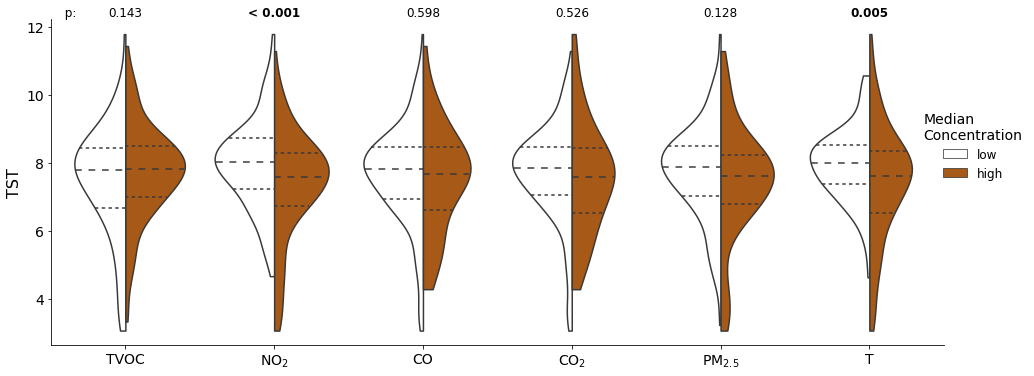

Running for: rem2nrem


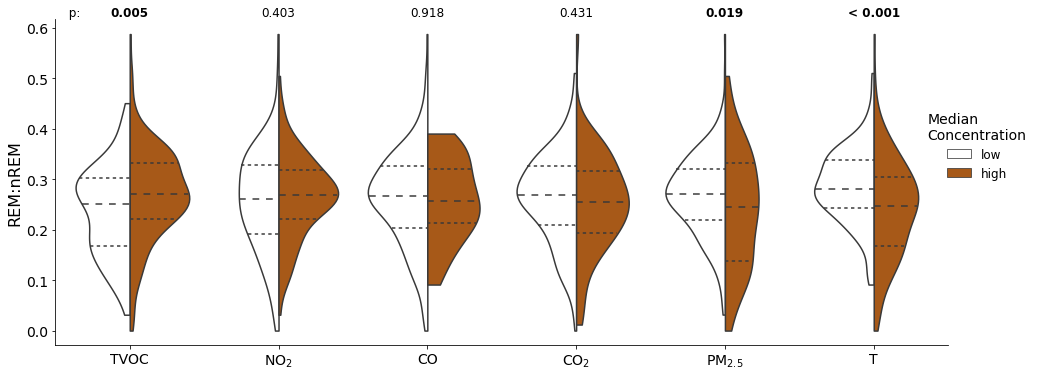

Running for: efficiency


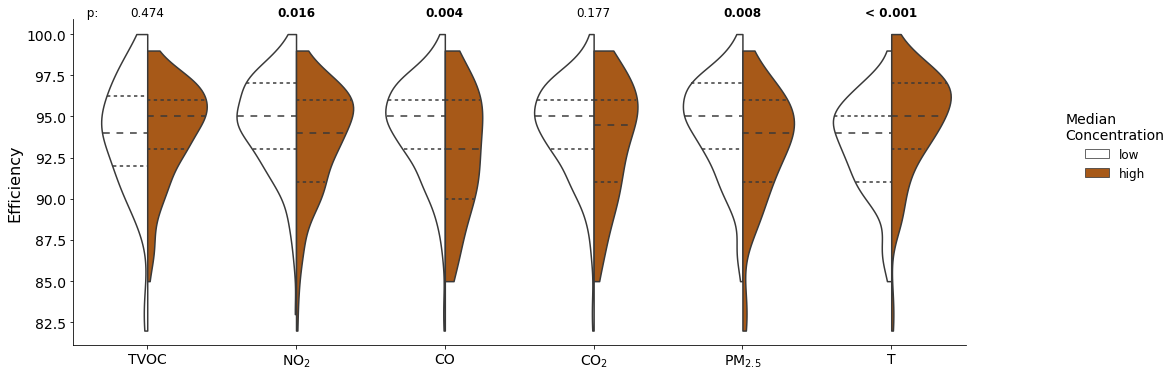

In [14]:
ttest_results = run_ttest_ieq_and_sleep(ieq_and_fb_sleep,save=True)

## Ventilation
Now we look at the relationship between ventilation and Fitbit-measured sleep metrics

### Merging Datasets
There are sometimes multiple ventilation rates per evening, but merging the datasets perserve these nights and duplicate the Fitbit measurements.

In [15]:
aer_and_fb = aer.merge(right=fb_sleep,on=["beiwe","end_date"])
aer_and_fb.head()

,beacon_x,beiwe,start,end,ach,method,end_date,start_date,deep_count,deep_minutes,light_count,light_minutes,rem_count,rem_minutes,wake_count,wake_minutes,efficiency,end_time,start_time,redcap,beacon_y,nrem_count,rem2nrem_count,nrem_minutes,rem2nrem_minutes,tst_fb,rem_percent,nrem_percent
0,21.0,lkkjddam,2020-08-12 13:16:00,2020-08-12 13:38:00,0.151,decay,2020-08-12,2020-08-12,3,52,34,291,7,65,35,65,93,2020-08-12 10:52:30,2020-08-12 02:59:30,12.0,21.0,37,0.189189,343,0.189504,7.883333,0.137421,0.725159
1,21.0,lkkjddam,2020-08-16 13:36:00,2020-08-16 14:08:00,0.143,decay,2020-08-16,2020-08-16,4,79,27,200,5,97,25,75,89,2020-08-16 11:53:00,2020-08-16 04:21:30,12.0,21.0,31,0.161290,279,0.347670,7.516667,0.215078,0.618625
2,21.0,lkkjddam,2020-08-18 12:48:00,2020-08-18 13:22:00,0.202,decay,2020-08-18,2020-08-18,3,64,24,215,6,97,25,44,94,2020-08-18 12:27:00,2020-08-18 05:26:30,12.0,21.0,27,0.222222,279,0.347670,7.000000,0.230952,0.664286
3,21.0,lkkjddam,2020-08-20 12:26:00,2020-08-20 12:52:00,0.078,decay,2020-08-20,2020-08-20,3,85,31,197,4,87,26,79,90,2020-08-20 11:46:30,2020-08-20 04:18:30,12.0,21.0,34,0.117647,282,0.308511,7.466667,0.194196,0.629464
4,21.0,lkkjddam,2020-08-20 14:14:00,2020-08-20 14:44:00,0.062,decay,2020-08-20,2020-08-20,3,85,31,197,4,87,26,79,90,2020-08-20 11:46:30,2020-08-20 04:18:30,12.0,21.0,34,0.117647,282,0.308511,7.466667,0.194196,0.629464


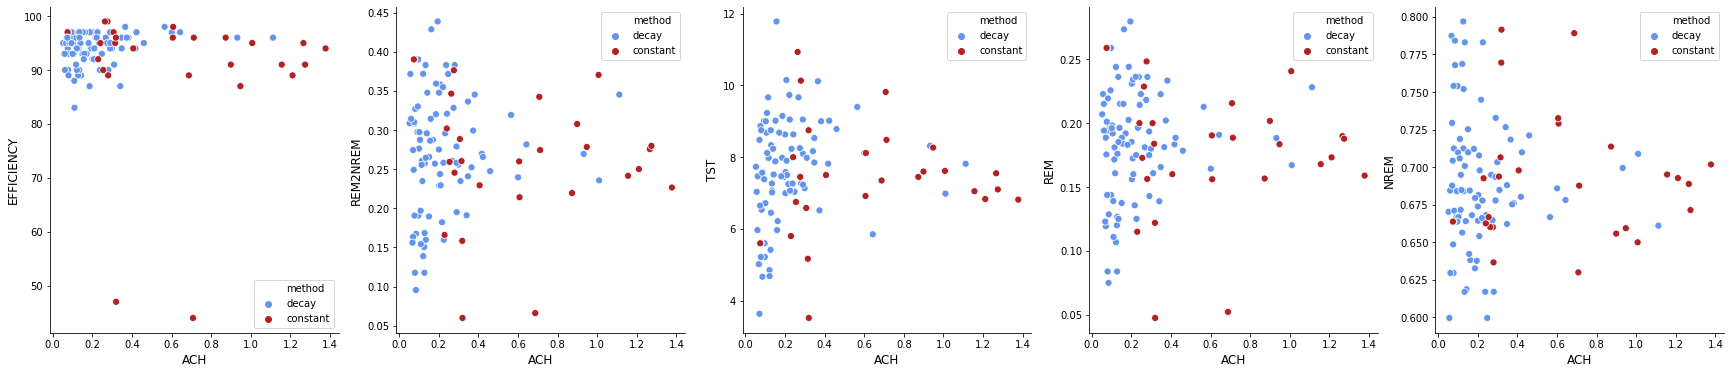

In [16]:
fig, axes = plt.subplots(1,len(sleep_metrics),figsize=(len(sleep_metrics)*6,6))
for sleep_metric, ax in zip(sleep_metrics, axes):
    sns.scatterplot(x="ach",y=sleep_metric,hue="method",data=aer_and_fb,
                    palette=["cornflowerblue","firebrick"],s=50,ax=ax)
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)
        
    
    ax.set_xlabel("ACH",fontsize=12)
    ax.set_ylabel(sleep_metric.split("_")[0].upper(),fontsize=12)

### Examining Distributions of Sleep Metrics Based on Low/High Ventilation Rates
We can parse out the ventilation rates into `low` and `high` values by looking at some of the recommendations given by ASHRAE standard 62.2. The standard recommends a ventilation rate of 0.35 ACH per person. Most, if not all of our participants, should be the only occupants of their bedrooms. Therefore, we can use the 0.35 ACH as our cutoff point between the distributions.

In [17]:
def plot_binary_violin(df_in, yvar="tst_fb", binary_var="ventilation_quality", ylabel="Sleep Time (h)", save=False, save_dir="../reports/figures/beacon_fitbit"):
    """Plots violin plots of concentration distributions for positive and negative restfulness scores"""
    df = df_in.copy()
    fig, ax = plt.subplots(figsize=(6,6))
    df["target"] = yvar
    violin_axes = sns.violinplot(x="target",y=yvar,hue=binary_var,split=True,palette=["white","cornflowerblue"],data=df,ax=ax,cut=0,inner="quartile",)
    for loc in ["right","top","bottom"]:
        ax.spines[loc].set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.get_legend().remove()
    ax.set_ylabel(ylabel,fontsize=18)
    plt.yticks(fontsize=14)
    ax.legend(title="Ventilation Quality",ncol=1,frameon=False,title_fontsize=14,fontsize=12)

    low_vals = df[df[binary_var] == "Inadequate"]
    high_vals = df[df[binary_var] == "Adequate"]
    _, p = stats.ttest_ind(low_vals[yvar],high_vals[yvar], equal_var=True)

    if p > 0:
        # Annotating with p-values
        xloc = ax.get_xticks()
        weight="bold" if p < 0.05 else "normal"
        ax.text(xloc-0.07,ax.get_ylim()[1],"p: ",fontsize=12,ha="center",va="bottom")
        ax.text(xloc,ax.get_ylim()[1],f"{round(p,3)}",fontsize=12,ha="center",va="bottom",weight=weight)

    if save:
        plt.savefig(f"{save_dir}/{yvar}-{binary_var}-violin.png", bbox_inches="tight")
        
    plt.show()
    plt.close()

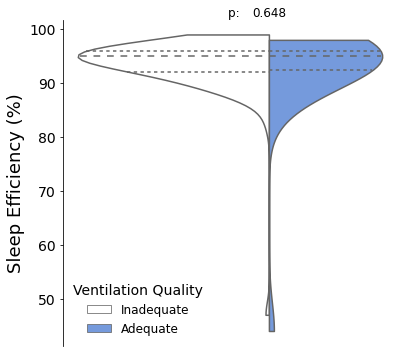

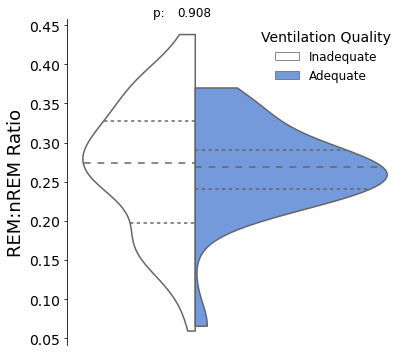

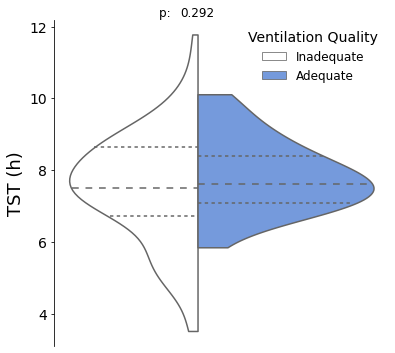

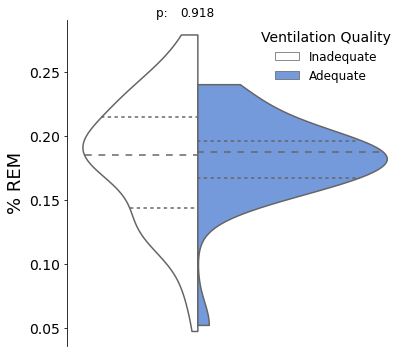

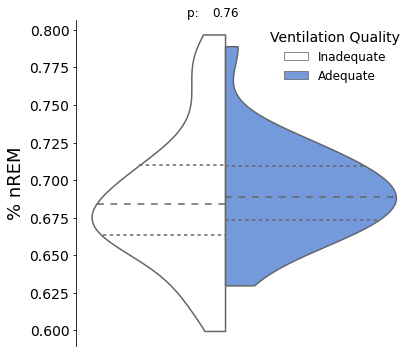

In [18]:
aer_and_fb["ventilation_quality"] = ["Adequate" if rate >= 0.35 else "Inadequate" for rate in aer_and_fb["ach"]]
for sleep_metric in sleep_metrics:
    plot_binary_violin(aer_and_fb, sleep_metric, ylabel=visualize.get_sleep_label(sleep_metric), save=True)

# Self-Report Sleep Metrics
Next, we see how the results change if we consider self-report sleep metrics.

## Pre-Processing
There are a few tweaks to the original dataset that we want to make.

### Binary Restful Score
We can group the restfulness score into a binary output:
* negative: 0 or 1
* positive: 2 or 3

In [19]:
beiwe_sleep["restful_binary"] = ["Positive" if score > 1 else "Negative" for score in beiwe_sleep["restful"]]

### Three-Point Scale
Since the lowest `restful` score has so few respondents, we can group the restfulness scores into three bins which also normalizes the largest bin as the middle score (which is probably more accurate).

In [20]:
beiwe_sleep["restful_three"] = [score if score != 0 else 1 for score in beiwe_sleep["restful"]]

### Merging Datasets
Two datasets need to be created:

#### IEQ and and Beiwe

In [21]:
beiwe_sleep["end_date"] = pd.to_datetime(beiwe_sleep["timestamp"].dt.date)
ieq["end_date"] = pd.to_datetime(ieq["end_time"].dt.date)
ieq_and_bw_sleep = ieq.merge(right=beiwe_sleep, on=["end_date","beiwe","redcap","beacon"])

#### Ventilation Rates and Beiwe

In [22]:
aer_and_bw = aer.merge(right=beiwe_sleep, on=["beiwe","end_date"])

#### Summarizing Results

In [23]:
print("Number of Observations:", len(ieq_and_bw_sleep))

Number of Observations: 192


In [24]:
print("Number of Participants:", len(ieq_and_bw_sleep["beiwe"].unique()))

Number of Participants: 16


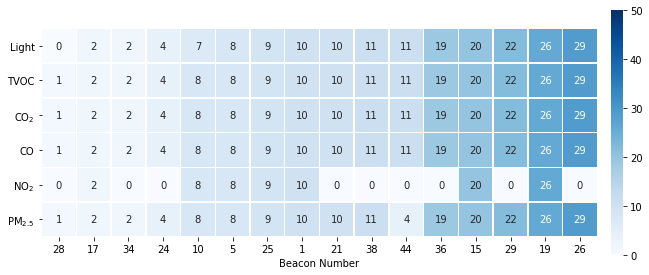

In [25]:
temp = plot_data_availability_heatmap(ieq_and_bw_sleep,agg_str="_median",save=True)

## Restfulness Scores
Restfulness scores lend themselves to some analysis on the concentrations by grouping by score

### Joyplots
We can construct some joyplots to get a sense of the data we have.

In [26]:
def plot_joyplot(df, pollutant_aggregate, by_var="restful", save=False, save_dir="../reports/figures/beacon_ema"):
    """Joyplot of pollutant aggregate profile for various restful scores"""
    c = df[by_var].value_counts().sort_index()
    new_labels = []
    for i, count in enumerate(c):
        new_labels.append(f"{i} ({count})")
    _, axes = joyplot(data=df,by=by_var,column=pollutant_aggregate,
                kind='kde',overlap=1,ylim='own',grid="y",labels=[""]*len(c),alpha=1,linewidth=2,colormap=LinearSegmentedColormap.from_list("", ["white","cornflowerblue"]),figsize=(8,6))
    agg = pollutant_aggregate.split("_")[-1]
    axes[-1].set_xlabel(f"Nightly {pollutant_aggregate.split('_')[-1].title()} {visualize.get_pollutant_label(pollutant_aggregate.split(f'_{agg}')[0])} Concentration ({visualize.get_pollutant_units(pollutant_aggregate.split(f'_{agg}')[0])})", fontsize=18)
    for ax, label in zip(axes, new_labels):
        ax.set_ylabel(label, rotation=0, va="top", fontsize=14)
        ax.set_xlim(left=0)
        
    plt.xticks(fontsize=14)
    fig.text(-0.1,0.5,"Restful Score (n)", va="center",fontsize=18,rotation=90)
    if save:
        plt.savefig(f"{save_dir}/{pollutant_aggregate}-{by_var}-joyplot.pdf", bbox_inches="tight")
    plt.show()
    plt.close()

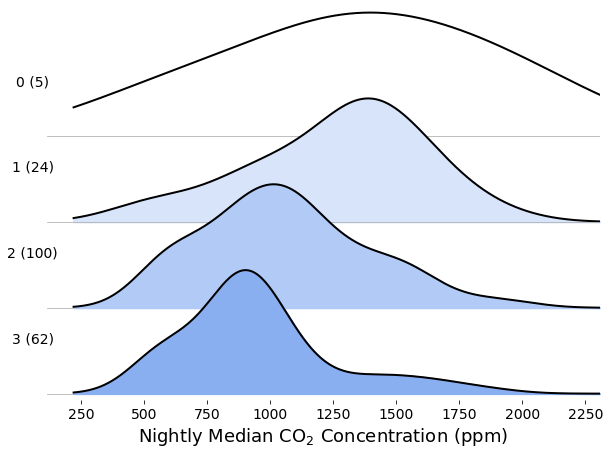

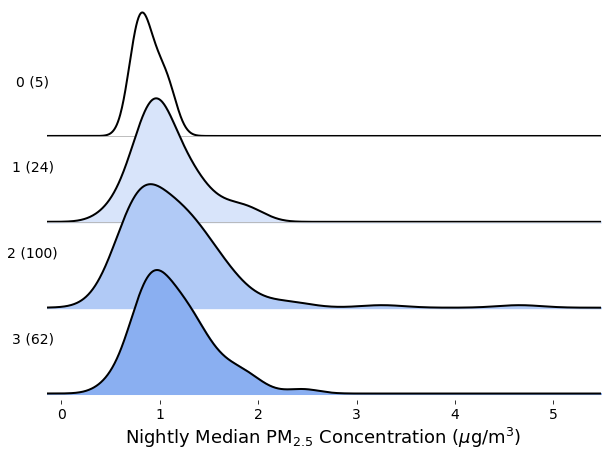

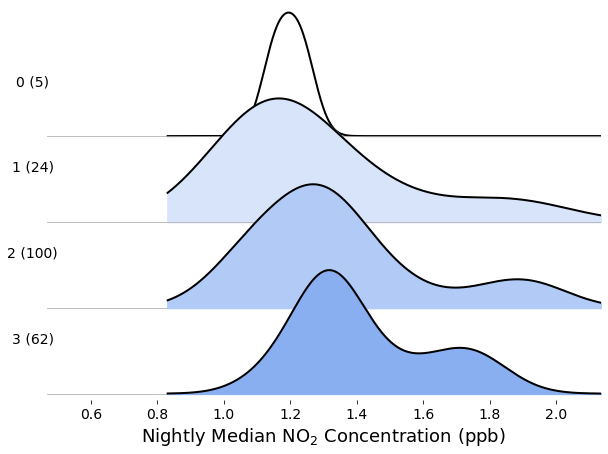

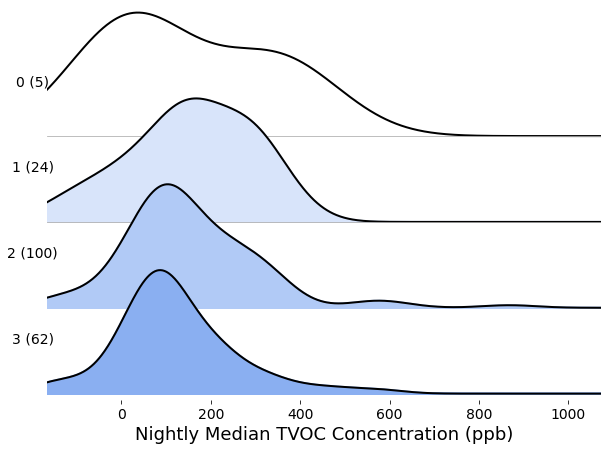

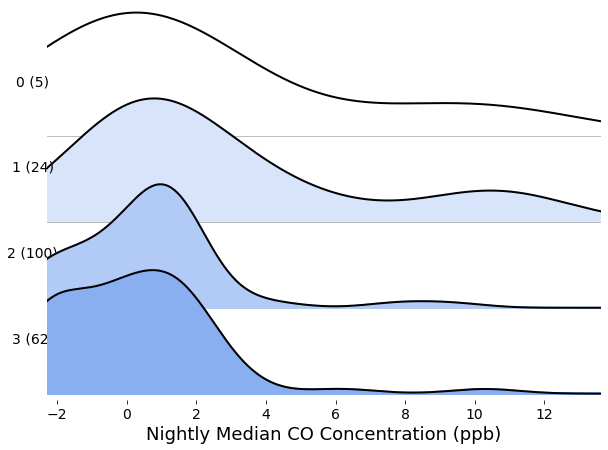

In [27]:
for pollutant in ["co2","pm2p5_mass","no2","tvoc","co"]:
    plot_joyplot(ieq_and_bw_sleep, f"{pollutant}_median")

<div class="alert alert-block alert-success">
 
It looks like there is a relationship between the `restful` score and `co2` as well as `tvoc`. Rather than looking at the four scores, we could try lumping 0 and 1 together or just doing a positive/negative response.
    
</div>

### Analysis on Three-Point Scale
We can do some more interesting ANalaysis Of VAriance (ANOVA) on the three restfulness scores and see if there are significant differences between the distributions.

In [28]:
for pollutant in ["co2","pm2p5_mass","no2","tvoc","co"]:
    pollutant_df = ieq_and_bw_sleep[[f"{pollutant}_median","restful_three"]]
    pollutant_df.dropna(subset=["restful_three"],inplace=True)
    grps = pd.unique(pollutant_df["restful_three"].values)
    d_data = {grp:pollutant_df[f"{pollutant}_median"][pollutant_df["restful_three"] == grp] for grp in grps}
    f, p = stats.f_oneway(d_data[1],d_data[2],d_data[3])
    print(f"Standard Deviations of Distributions for {visualize.get_pollutant_label(pollutant)}")
    for key in d_data.keys():
        li = d_data[key]
        print("\t", np.std(li))

    m_comp = pairwise_tukeyhsd(endog=pollutant_df[f'{pollutant}_median'], groups=pollutant_df['restful_three'], alpha=0.05)
    print(m_comp)

Standard Deviations of Distributions for CO$_2$
	 380.13903338313077
	 339.7582260057754
	 308.6453082448054
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj    lower     upper   reject
---------------------------------------------------------
   1.0    2.0 -229.3285 0.0045 -398.3876  -60.2693   True
   1.0    3.0  -348.442  0.001 -528.7723 -168.1118   True
   2.0    3.0 -119.1136 0.0788 -248.6836   10.4564  False
---------------------------------------------------------
Standard Deviations of Distributions for PM$_{2.5}$
	 0.2992222075739644
	 0.5483774222708506
	 0.36294218993682886

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower upper reject
------------------------------------------------
   1.0    2.0      nan 0.5566   nan   nan  False
   1.0    3.0      nan 0.5566   nan   nan  False
   2.0    3.0      na

<div class="alert alert-block alert-success">
 
Seems that there are significant differences for the `co2` and `co` concentration profiles between some restfulness scores. We can see better results if we consider only binary outputs for the `restful` score. 
    
</div>

### Binary Restfulness Scores
By using the binary restfulness scores, we can create distributions of pollutants based on positive and negative restulfness scores.

In [29]:
def plot_restful_violin(df_in, target="co2_median", save=False, save_dir="../reports/figures", subfolder="beacon_ema"):
    """Plots violin plots of concentration distributions for positive and negative restfulness scores"""
    df = df_in.copy()
    fig, ax = plt.subplots(figsize=(4,4))
    df["target"] = target
    violin_axes = sns.violinplot(x="target",y=target,hue="restful_binary",hue_order=["Negative","Positive"],split=True,palette=["white","seagreen"],data=df,ax=ax,cut=0,inner="quartile",)
    for loc in ["right","top","bottom"]:
        ax.spines[loc].set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.get_legend().remove()
    if target.split("_")[-1].lower() == "median":
        ax.set_ylabel(f"Nightly Median {visualize.get_pollutant_label(pollutant)} ({visualize.get_pollutant_units(pollutant)})",fontsize=18)
    else:
        ax.set_ylabel("Ventilation Rate (ACH)",fontsize=18)
    plt.yticks(fontsize=14)
    ax.legend(loc="center",bbox_to_anchor=(0.5,-0.1),title="Restful Response",ncol=2,frameon=False,title_fontsize=14,fontsize=12)

    low_vals = df[df["restful_binary"] == "Negative"]
    high_vals = df[df["restful_binary"] == "Positive"]
    _, p = stats.ttest_ind(low_vals[target],high_vals[target], equal_var=True)

    if p > 0:
        # Annotating with p-values
        xloc = ax.get_xticks()
        weight="bold" if p < 0.05 else "normal"
        val = round(p,3) if p > 0.001 else "< 0.001"
        ax.text(xloc,ax.get_ylim()[1],f"p: {val}",fontsize=12,ha="center",va="bottom",weight=weight)

    if save:
        plt.savefig(f"{save_dir}/{subfolder}/{target}-binary_restful-violin.pdf", bbox_inches="tight")
    plt.show()
    plt.close()

#### Pollutant Concentration Profiles and Restfulness Scores
Here we look at the pollutant concentration profiles for `negative` and `positive` `restful` scores.

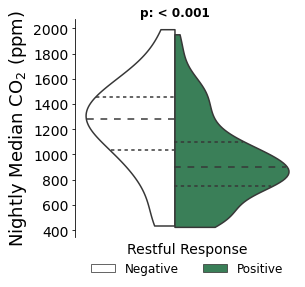

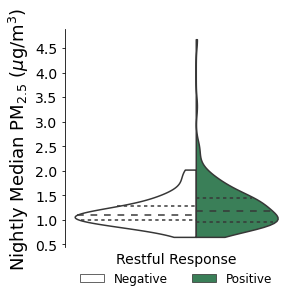

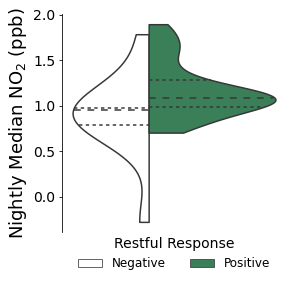

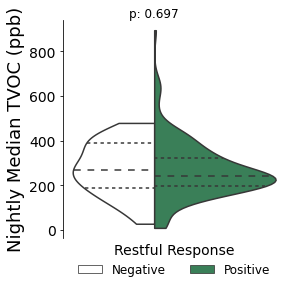

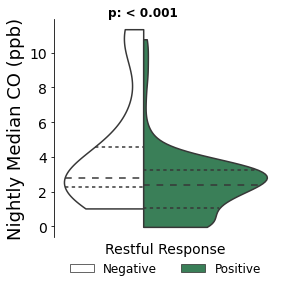

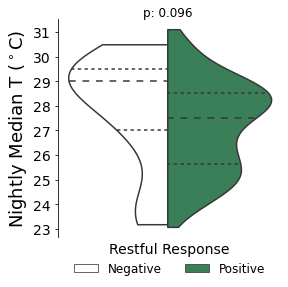

In [30]:
for pollutant in ["co2","pm2p5_mass","no2","tvoc","co","temperature_c"]:
    plot_restful_violin(ieq_and_bw_sleep, target=f"{pollutant}_median", save=True,)

#### Ventilation and Restfulness Scores
Similar to above, but now looking at `ach` for `negative` and `positive` `restful` scores.

In [31]:
def plot_restful_swarm(df_in, target="co2_median", save=False, save_dir="../reports/figures", subfolder="beacon_ema"):
    """Plots violin plots of concentration distributions for positive and negative restfulness scores"""
    df = df_in.copy()
    fig, ax = plt.subplots(figsize=(6,6))
    df["target"] = target
    violin_axes = sns.swarmplot(x="target",y=target,hue="restful_binary",hue_order=["Negative","Positive"],split=True,palette=["black","cornflowerblue"],size=10,data=df,ax=ax)
    for loc in ["right","top","bottom"]:
        ax.spines[loc].set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.get_legend().remove()
    if target.split("_")[-1].lower() == "median":
        ax.set_ylabel(f"Nightly Median {visualize.get_pollutant_label(pollutant)} Concentration ({visualize.get_pollutant_units(pollutant)})",fontsize=18)
    else:
        ax.set_ylabel("Ventilation Rate (ACH)",fontsize=18)
    plt.yticks(fontsize=14)
    ax.legend(loc="center",bbox_to_anchor=(0.5,-0.1),title="Restful Response",ncol=2,frameon=False,title_fontsize=14,fontsize=12)

    low_vals = df[df["restful_binary"] == "Negative"]
    high_vals = df[df["restful_binary"] == "Positive"]
    _, p = stats.ttest_ind(low_vals[target],high_vals[target], equal_var=True)

    if p > 0:
        # Annotating with p-values
        xloc = ax.get_xticks()
        weight="bold" if p < 0.05 else "normal"
        ax.text(xloc-0.07,ax.get_ylim()[1],"p: ",fontsize=12,ha="center",va="bottom")
        ax.text(xloc,ax.get_ylim()[1],f"{round(p,3)}",fontsize=12,ha="center",va="bottom",weight=weight)

    if save:
        plt.savefig(f"{save_dir}/{subfolder}/{target}-binary_restful-swarm.png", bbox_inches="tight")
    plt.show()
    plt.close()

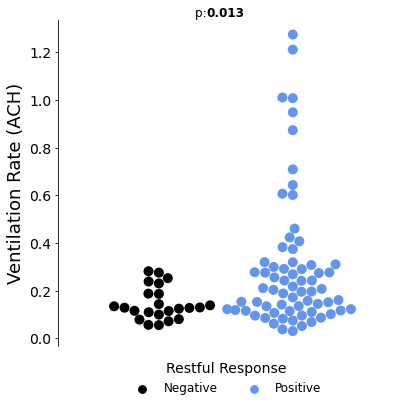

In [32]:
plot_restful_swarm(aer_and_bw, target="ach", save=True)

## Sleep Onset Latency

In [33]:
ieq_and_bw_sleep.head()

,start_time,end_time,beacon,beiwe,fitbit,redcap,tvoc_median,lux_median,no2_median,co_median,co2_median,pm2p5_number_median,pm2p5_mass_median,temperature_c_median,tvoc_delta,lux_delta,no2_delta,co_delta,co2_delta,pm2p5_number_delta,pm2p5_mass_delta,temperature_c_delta,end_date,timestamp,content,stress,lonely,sad,energy,tst,sol,naw,restful,restful_binary,restful_three
0,2020-08-10 04:42:30,2020-08-10 12:35:30,21,lkkjddam,25,12,126.658333,2.040,NaN,10.359917,1600.754959,0.914249,0.895571,23.337500,91.900000,0.136,NaN,0.731650,304.035761,1.960803,0.620298,1.000,2020-08-10,2020-08-10 12:56:38,1,2.0,0.0,0.0,2.0,6.0,15.0,5.0,0.0,Negative,1.0
1,2020-08-12 02:59:30,2020-08-12 10:52:30,21,lkkjddam,25,12,252.016667,2.040,NaN,10.271850,1596.122408,2.879650,0.939256,24.000000,108.600000,0.204,NaN,0.512533,146.009840,5.472740,0.702017,0.000,2020-08-12,2020-08-12 11:11:42,2,3.0,0.0,0.0,2.0,8.0,10.0,3.0,2.0,Positive,2.0
2,2020-08-14 03:05:00,2020-08-14 11:23:30,21,lkkjddam,25,12,223.700000,1.938,NaN,7.232700,1301.449844,1.232406,0.886675,25.000000,81.800000,2.040,NaN,5.108383,233.372161,3.742991,0.736714,1.175,2020-08-14,2020-08-14 15:02:44,2,3.0,1.0,2.0,3.0,8.0,10.0,3.0,3.0,Positive,3.0
3,2020-08-16 04:21:30,2020-08-16 11:53:00,21,lkkjddam,25,12,268.650000,0.408,NaN,10.486333,1319.535880,1.256692,0.884277,24.000000,88.216667,2.040,NaN,0.312050,96.153213,3.655915,0.471061,0.500,2020-08-16,2020-08-16 12:25:03,1,2.0,1.0,2.0,1.0,6.0,20.0,4.0,1.0,Negative,1.0
4,2020-08-17 03:00:00,2020-08-17 11:30:30,21,lkkjddam,25,12,327.166667,1.972,NaN,11.025200,1412.926806,2.952962,1.113030,23.333333,249.066667,2.040,NaN,0.819100,331.097623,7.407653,1.358703,1.750,2020-08-17,2020-08-17 11:41:47,1,2.0,1.0,1.0,1.0,6.0,25.0,2.0,1.0,Negative,1.0


Running for: sol


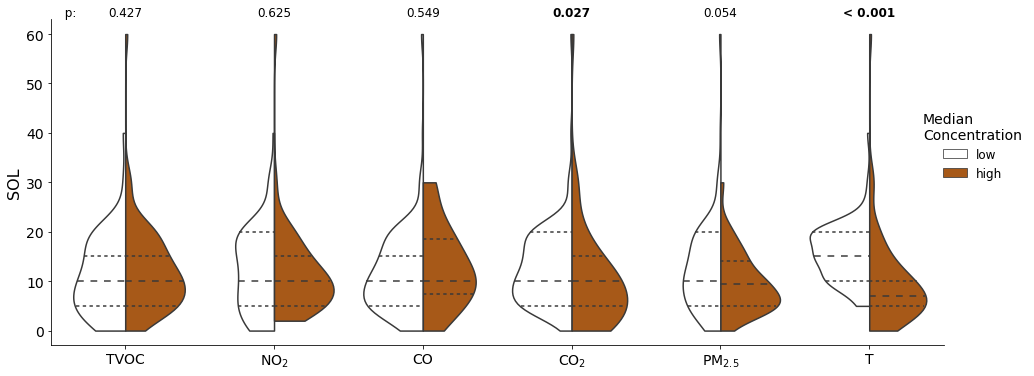

{'sol':                low  high     p_val
 pollutant                         
 tvoc            53   139  0.426721
 no2             83   109  0.624523
 co             169    23  0.549462
 co2            130    62  0.027470
 pm2p5_mass     150    42  0.054222
 temperature_c   71   121  0.000003}

In [34]:
run_ttest_ieq_and_sleep(ieq_and_bw_sleep,sleep_metrics=["sol"], sleep_device="ema", save=True, )